# Processing di segnali mono-dimensionali

Il task è riconoscere a partire da un file audio, l’identità di chi sta
parlando
- L’identità è da riconoscere all’interno del gruppo di lavoro
- Potete decidere voi il livello di difficoltà:
    - Ogni utente ha la propria password (es. «1-4-9»)
    - Tutti gli utenti dicono la stessa frase (fissa)
    - Non c’è vincolo sulla frase che viene detta
    - Nessun vincolo sulle condizioni di acquisizione (es. forte eco, rumori di fondo,etc)

In [1]:
import IPython.display as ipd # Solo per Jupyter Notebook

import matplotlib.pyplot as plt
from matplotlib.mlab import find

from scipy.io import wavfile as wav
from scipy.fftpack import rfft, fft, irfft, ifft, fftfreq
from scipy.signal import fftconvolve

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale

import numpy as np
import os
import librosa
from time import time

import sounddevice as sd 

# Data Generator

In [37]:
duration = 2 # (secondi)
rec_rate = 44100

In [3]:
sd.default.channels

[None, None]

In [40]:
rec = sd.rec(int(duration * rec_rate), samplerate=rec_rate, channels=1, blocking=True)

In [39]:
import IPython.display as ipd
ipd.Audio(rec[:,0], rate=rec_rate)

Raccolta dati

In [15]:
duration = 2 # (secondi)
rec_rate = 44100

audio = []

for i in range(1,200) :
    rec = sd.rec(int(duration * rec_rate), samplerate=rec_rate, channels=1, blocking=True)
    wav.write('./audio2/silvia/'+ str(i) +'.wav', rate=rec_rate, data=rec)
    audio.append(rec)
    input("Press Enter to continue...")
    

Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
Press Enter to continue...
P

In [53]:
wav.write('audio/ex.wav', rate=rec_rate, data=audio[1])

In [5]:
import IPython.display as ipd
ipd.Audio(audio[10][:,0], rate=rec_rate)

NameError: name 'audio' is not defined

In [56]:
#plt.plot(rec[:,0])
#plt.show()

# Data Loader

In [44]:
# Feature dummy
def identity(input):
    return input[0:100]*1.0

# Data loader
def load_data(feature_extractor=identity, normalize=True):

    labels = []
    features = []

    base_path = './audio2/'
    for di,d in enumerate(sorted(os.listdir(base_path))):
        for fi,f in enumerate(sorted(os.listdir(base_path + d + '/'))):
            if f.endswith('.wav'):
                # Carica file ed estraine le features
                _, signal = wav.read(base_path + d + '/' + f)
                cur_features = feature_extractor(signal)
                features.append(cur_features)

                # Categorie
                labels.append(di)
                
            
    # Separazione training / test set
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=1)
    # X: features, y: labels

    # Normalizza ciascuna dimensione delle feature
    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test, X_train_mean, X_train_std

In [41]:
signal = rec[:,0][::3] # campiona un valore ogni 3
signal*0.1
mfcc = librosa.feature.mfcc(signal*1.0, sr=rec_rate) # calcola coefficienti mfcc
mfcc.shape[1]

58

In [42]:
def mfcc(input, rate=rec_rate, min_len=58):
    signal = input[::3] # campiona un valore ogni 3
    mfcc = librosa.feature.mfcc(signal*1.0, sr=rate) # calcola coefficienti mfcc
    pad_width = min_len - mfcc.shape[1] # rendi rappresentazione tutta della stessa lunghezza
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc.flatten()

# Addestramento 

In [45]:
# Caricamento dati
X_train, X_test, y_train, y_test, X_train_mean, X_train_std = load_data(feature_extractor=mfcc)

# Parametri da provare in cross validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Inizializzazione Support Vector Machine
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Addestramento
t0 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t0))

# Risultato della cross validation
print("Migliore combinazione di parametri:")
print(" C: "+str(clf.best_estimator_.C))
print(" gamma: "+str(clf.best_estimator_.gamma))

c:\users\silvia.bordogna\appdata\local\continuum\anaconda2\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Addestramento completato in 4.024s
Migliore combinazione di parametri:
 C: 100.0
 gamma: 0.005


# Test

Report di classificazione:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        52
           1       0.97      0.99      0.98        68

   micro avg       0.97      0.97      0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120

Matrice di confusione:
[[50  2]
 [ 1 67]]


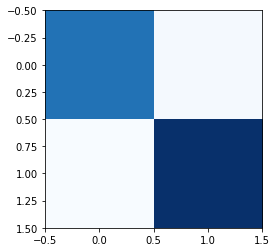

In [46]:
# Test
y_pred = clf.predict(X_test)

# Report di classificazione
print("Report di classificazione:")
print(classification_report(y_test, y_pred))

# Matrice di confusione
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

# Demo

In [47]:
rec = sd.rec(int(duration * rec_rate), samplerate=rec_rate, channels=1, blocking=True)

In [48]:
ipd.Audio(rec[:,0], rate=rec_rate)

In [49]:
wav.write('audio/'+ 'test.wav', rate=rec_rate, data=rec)

In [50]:
rate=rec_rate
min_len=58

signal = rec[:,0][::3] # campiona un valore ogni 3
mfcc = librosa.feature.mfcc(signal*1.0, sr=rate) # calcola coefficienti mfcc
pad_width = min_len - mfcc.shape[1] # rendi rappresentazione tutta della stessa lunghezza
mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
rec_feature = mfcc.flatten()



In [51]:
rec_feature.shape

(1160,)

In [52]:
eps = 0.001
test = (np.array(rec_feature) - X_train_mean + eps)/(X_train_std + eps)

In [53]:
pred = clf.predict(test.reshape(1, -1))

In [54]:
print(pred)

[1]


In [57]:
base_path = './audio2/'
for di,d in enumerate(sorted(os.listdir(base_path))):
    print(di , d)

0 giacomo
1 silvia
